### Notebook to genereate CFADS from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import cmocean
from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
# from stratiform_index import stratiform_index

#### Time selection

In [2]:
nt=3
hr_tag = np.char.zfill(str(nt), 2)
t0 = 48
t1 = t0+nt

xmin=780

#### Directories

In [3]:
figdir = "/Users/jruppert/code/tc_figs/"

# main = "/Users/jamesruppert/code/tc_output/"
main = "/Users/jruppert/code/tc_output/"
storm = !ls $main
# print(storm)

istorm=storm[0]
memb = !ls $main/$istorm
imemb=memb[0]
# print(main+istorm+'/'+imemb)

datdir = main+istorm+'/'+imemb+'/ctl/'
print(datdir)

/Users/jruppert/code/tc_output/haiyan/memb_01/ctl/


#### Read variables

In [4]:
# Two-dimensional variables

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain
varfil_strat = Dataset(datdir+'strat.nc') # this opens the netcdf file
strat = varfil_strat.variables['strat'][t0:t1,:,:,xmin:1400-1]
varfil_strat.close()

# PW
binfil = Dataset(datdir+'PW.nc') # this opens the netcdf file
pw = binfil.variables['PW'][t0:t1,:,:,xmin:1400-1]
binfil.close()

# LW-ACRE
binfil = Dataset(datdir+'LWacre.nc') # this opens the netcdf file
lwacre = binfil.variables['LWUPB'][t0:t1,:,:,xmin:1400-1] # W/m2
binfil.close()

# Rainfall
binfil = Dataset(datdir+'rainrate.nc') # this opens the netcdf file
rain = binfil.variables['rainrate'][t0:t1,:,:,xmin:1400-1] # mm/hr
binfil.close()

In [5]:
# Three-dimensional variables

# Vertical coordinate
filtmp = Dataset(datdir+'RTHRATLW.nc')
pres = filtmp.variables['pres'][:] # hPa
print("Vertical shape: ",np.shape(pres))
filtmp.close()

# Mixing ratio
varfil_main = Dataset(datdir+'QVAPOR.nc')
qv = varfil_main.variables['QVAPOR'][t0:t1,:,:,xmin:1400-1] # kg/kg
varfil_main.close()
units_var1 = 'kg/kg'

# Horizontal temperature anomaly
varfil_main = Dataset(datdir+'T.nc')
tmpk = varfil_main.variables['T'][t0:t1,:,:,xmin:1400-1] # K
varfil_main.close()
thv = theta_virtual(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
units_thp = 'K'
# Subtract time-dependent domain average
t_mean = np.mean(thv,axis=(2,3))
thv -= t_mean[:,:,np.newaxis,np.newaxis]

# Equiv pot temp
th_e = theta_equiv(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
# Subtract time-dependent domain average
t_mean = np.mean(th_e,axis=(2,3))
th_e -= t_mean[:,:,np.newaxis,np.newaxis]

# Density
rho = density_moist(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # kg/m3

bv_shape = np.shape(tmpk)
print("Binvar shape: ",bv_shape)
nt = bv_shape[0]
nz = bv_shape[1]
nx1 = bv_shape[2]
nx2 = bv_shape[3]

Vertical shape:  (10,)
Binvar shape:  (3, 10, 740, 619)


In [6]:
# Calculate th_v' as th_v[t] - th_v[t-1]
# thp = thv[range(1,nt),:,:,:] - thv[range(0,nt-1),:,:,:]

In [7]:
# Calculate th_e' as th_e[t] - th_e[t-1]
# thp = the[range(1,nt),:,:,:] - the[range(0,nt-1),:,:,:]

In [8]:
# # Th_v' weighted by qv'
# thv = theta_virtual(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
# thp = thv[range(1,nt),:,:,:] - thv[range(0,nt-1),:,:,:]
# qvp = np.absolute(qv[range(1,nt),:,:,:] - qv[range(0,nt-1),:,:,:])
# qvscale = np.mean(qvp,axis=(2,3))
# qvp /= qvscale[:,:,np.newaxis,np.newaxis]
# thp *= qvp

In [9]:
# Vertical motion
varfil_cvar = Dataset(datdir+'W.nc') # this opens the netcdf file
w = varfil_cvar.variables['W'][t0:t1,:,:,xmin:1400-1] # m/s
varfil_cvar.close()
w *= rho
units_var2='kg m$^{-2}$ s$^{-1}$'
# lcmin = -20; lcmax=20; lcint=2

In [10]:
# # Calculate w' as w[t] - w[t-1]
# wp = w[range(1,nt),:,:,:] - w[range(0,nt-1),:,:,:]

In [11]:
# Calculate basic VMF mean
w_mn = np.mean(w,axis=(0,2,3))

#### Calculate VMF

In [12]:
# # Vmf in lower and upper trop
# dp = 10000. # Pa
# g = 9.81 # m/s2
# ktop1=500
# ktop2=100
# iktop1 = np.where(pres == ktop1)[0][0]
# iktop2 = np.where(pres == ktop2)[0][0]

# # Layer VMF = -1/g SUM(w * dp) = m/s * s**2/m * kg/m/s**2 = kg/s/m
# vmf_lower = np.mean(w[:,0:iktop1,:,:],1) * dp/g
# vmf_upper = np.mean(w[:,iktop1:iktop2,:,:],1) * dp/g
# vmf_lower = np.reshape(vmf_lower,(nt,1,nx1,nx2))
# vmf_upper = np.reshape(vmf_upper,(nt,1,nx1,nx2))
# vmf = vmf_lower + vmf_upper
# vmf_th = (vmf_upper - vmf_lower) / vmf

#### Calculate frequency

In [13]:
# nbin=60

# fmin=-3; fmax=5
# fmin=-5; fmax=5
# step=(fmax-fmin)/nbin
# wbins=np.arange(fmin,fmax,step)

# w_freq=np.zeros((nbin,nz))
# w_freq2=np.zeros((nbin,nz))

# # fmin=-5; fmax=5
# fmin=-10; fmax=10
# step=(fmax-fmin)/nbin
# hstep=step*0.5
# thvbins=np.arange(fmin,fmax,step)
# thv_freq=np.zeros((nbin,nz))

# for iz in range(nz):
#     for ibin in range(nbin):
#         # indices = ((w[:,iz,:,:] >= wbins[ibin]) & (w[:,iz,:,:] < wbins[ibin+1])).nonzero()
#         indices = ((wp[:,iz,:,:] >= wbins[ibin]-hstep) & (wp[:,iz,:,:] < wbins[ibin]+hstep)).nonzero()
#         w_freq[ibin,iz]=np.shape(indices)[1]
#         indices = ((wp[:,iz,:,:]*1.2 >= wbins[ibin]-hstep) & (wp[:,iz,:,:]*1.2 < wbins[ibin]+hstep)).nonzero()
#         w_freq2[ibin,iz]=np.shape(indices)[1]
#         # indices = ((thp[:,iz,:,:] >= thvbins[ibin]) & (thp[:,iz,:,:] < thvbins[ibin+1])).nonzero()
#         # thv_freq[ibin,iz]=np.shape(indices)[1]

# # print(np.max(w_freq))
# # print(np.min(w_freq))

# ncell=nx1*nx2*nt
# # print(ncell)
# w_freq *= 100./ncell
# w_freq2 *= 100./ncell
# thv_freq *= 100./ncell

# # print(np.max(w_freq))
# # print(np.min(w_freq))

In [14]:
# wbins=10.**np.arange(-7,3)
# wbins=[np.arange(1,11)*1e-3,2]
wbins=np.logspace(-3,1.1,num=20)
wbins=np.concatenate((-1.*np.flip(wbins),wbins))
nbin=np.shape(wbins)[0]
# print(wbins)
# print(nbin)

w_freq=np.zeros((nbin-1,nz))
w_freq2=np.zeros((nbin-1,nz))

# fmin=-5; fmax=5
# fmin=-10; fmax=10
# step=(fmax-fmin)/nbin
# hstep=step*0.5
# thvbins=np.arange(fmin,fmax,step)
# thv_freq=np.zeros((nbin,nz))

for iz in range(nz):
    for ibin in range(nbin-1):
        indices = ((w[:,iz,:,:] >= wbins[ibin]) & (w[:,iz,:,:] < wbins[ibin+1])).nonzero()
        # indices = ((wp[:,iz,:,:] >= wbins[ibin]-hstep) & (wp[:,iz,:,:] < wbins[ibin]+hstep)).nonzero()
        w_freq[ibin,iz]=np.shape(indices)[1]
        scale = 1.5
        indices = ((w[:,iz,:,:]*scale >= wbins[ibin]) & (w[:,iz,:,:]*scale < wbins[ibin+1])).nonzero()
        w_freq2[ibin,iz]=np.shape(indices)[1]
        # indices = ((thp[:,iz,:,:] >= thvbins[ibin]) & (thp[:,iz,:,:] < thvbins[ibin+1])).nonzero()
        # thv_freq[ibin,iz]=np.shape(indices)[1]

ncell=nx1*nx2*nt
w_freq *= 100./ncell
w_freq2 *= 100./ncell
# thv_freq *= 100./ncell

# Create axis of bin center-points
wbin_axis = (wbins[np.arange(nbin-1)]+wbins[np.arange(nbin-1)+1])/2
# print(wbin_axis)

---
### Plotting routines

In [17]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

### Plot profiles

/var/folders/8d/7vfq6vq90w341ddvxxt1k4540000gn/T/ipykernel_23411/3257249080.py:42: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf(wbin_axis, pres, np.transpose(w_freq), clevs, norm=colors.LogNorm(),


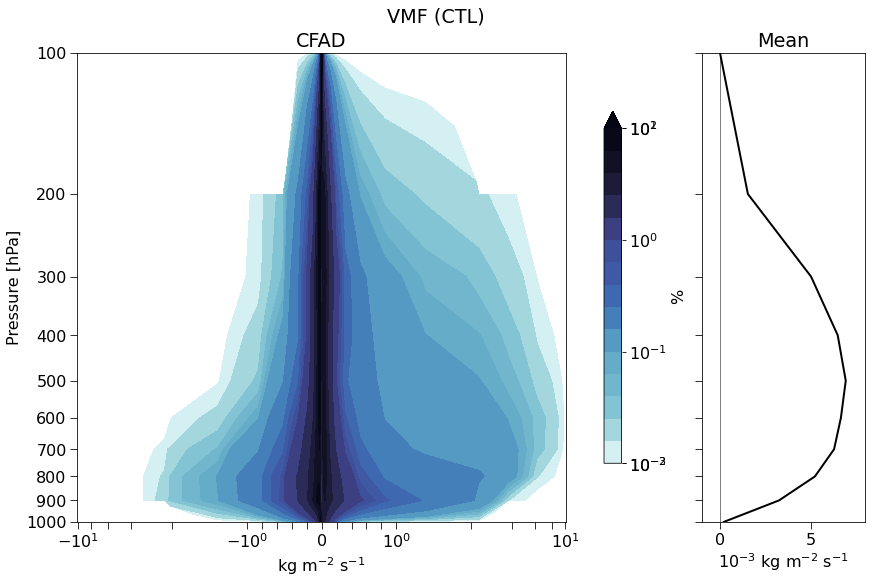

In [18]:
# create figure

# fig = plt.figure(figsize=(14,8))
# ax = fig.add_subplot(111)

test='ctl'

fig, axd = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [3, 1]},
                        constrained_layout=True, figsize=(12, 8))

fig.suptitle('VMF ('+test.upper()+')')

for col in range(2):
    
    ax = plt.subplot(1,2,1+col)
    
    ax.set_yscale('log')
    
    ax.invert_yaxis()
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    
    ax.set_xlabel(units_var2)
    
    ax.tick_params(axis='both',length=7)
    
    plt.yticks(ticks=pres)
    plt.ylim(np.max(pres), np.min(pres))


####### Fill contour ##############

ax = plt.subplot(121)

ax.set_title('CFAD')
ax.set_ylabel('Pressure [hPa]')
ax.set_xscale('symlog')

#clevs=[0.005,0.01,0.05,0.1,0.5,1,5,10,50]
clevs=np.concatenate(([1e-2],np.arange(2,11,2)*1e-2,np.arange(2,11,2)*1e-1,np.arange(2,11,2)))

im = ax.contourf(wbin_axis, pres, np.transpose(w_freq), clevs, norm=colors.LogNorm(),
                 cmap=cmocean.cm.ice_r, alpha=1.0, extend='max', zorder=2)

plt.xlim(np.min(wbin_axis), np.max(wbin_axis))
locmin = ticker.SymmetricalLogLocator(base=10.0,linthresh=2,subs=np.arange(2,11,2)*0.1)
ax.xaxis.set_major_locator(locmin)
# ax.xaxis.set_minor_formatter(ticker.NullFormatter())

cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.LogLocator(base=10.0), 
                    format=ticker.LogFormatterMathtext())
cbar.ax.set_ylabel('%')


####### Mean profile ##############

ax = plt.subplot(122)

ax.set_title('Mean')
ax.yaxis.set_major_formatter(ticker.NullFormatter())

w_plt=w_mn*1e3
ax.plot(w_plt, pres, "-k", linewidth=2)
plt.xlim(-1,8)
plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel('$10^{-3}$ '+units_var2)

plt.show()
# plt.savefig(figdir+'cfad_'+fig_tag+'_ens5m_'+itest+'_'+hr_tag+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)

/var/folders/8d/7vfq6vq90w341ddvxxt1k4540000gn/T/ipykernel_22377/753177732.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf(wbin_axis, pres, np.transpose(w_freq), clevs, norm=colors.LogNorm(), \


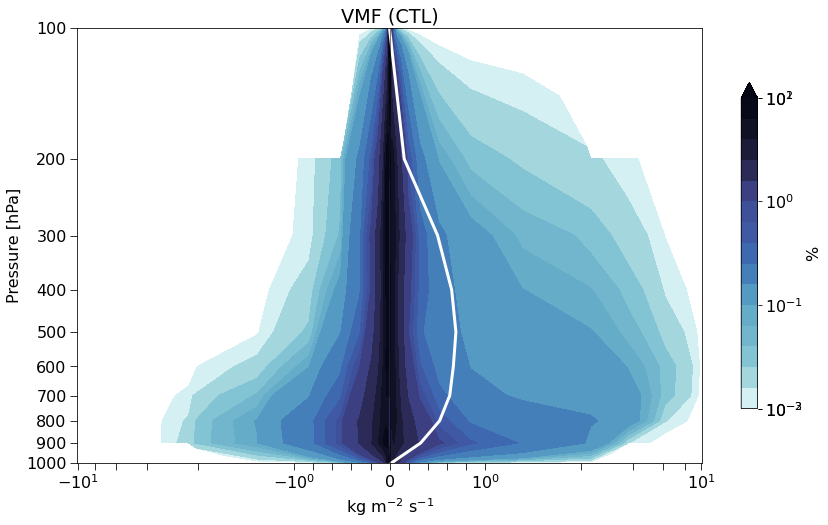

In [46]:
# create figure

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

test='ctl'
ax.set_title('VMF ('+test.upper()+')')
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')
ax.set_xscale('symlog')

# fill contour
#clevs=[0.005,0.01,0.05,0.1,0.5,1,5,10,50]
clevs=np.concatenate(([1e-2],np.arange(2,11,2)*1e-2,np.arange(2,11,2)*1e-1,np.arange(2,11,2)))

im = ax.contourf(wbin_axis, pres, np.transpose(w_freq), clevs, norm=colors.LogNorm(), \
                 # cmap='GnBu', alpha=1, extend='max', zorder=2)
                 cmap=cmocean.cm.ice_r, alpha=1.0, extend='max', zorder=2)

plt.plot(w_mn*1e2, pres, "-w", linewidth=3)

plt.yticks(ticks=pres)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.ylim(np.max(pres), np.min(pres))

locmin = ticker.SymmetricalLogLocator(base=10.0,linthresh=2,subs=np.arange(2,11,2)*0.1)
ax.xaxis.set_major_locator(locmin)
# ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.xlim(np.min(wbin_axis), np.max(wbin_axis))

plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel(units_var2)

ax.tick_params(axis='both',length=7)

cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.LogLocator(base=10.0), format=ticker.LogFormatterMathtext())
cbar.ax.set_ylabel('%')

plt.show()
# plt.savefig(figdir+'cfad_'+fig_tag+'_ens5m_'+itest+'_'+hr_tag+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)

---

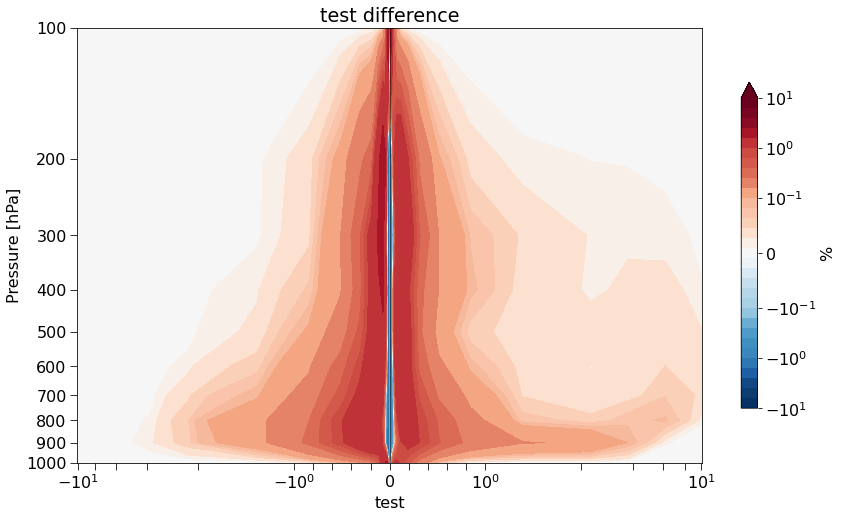

In [38]:
# Testing out SymLog approach

# ### Plot difference CFAD

# var_diff = NCRF - CTL
pltvar = np.transpose( w_freq2-w_freq )

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title('test difference')
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')
ax.set_xscale('symlog')

# fill contour
# clevsi=[0.005,0.01,0.05,0.1,0.5,1,5,10,50]
clevsi=np.concatenate(([1e-2],np.arange(2,11,2)*1e-2,np.arange(2,11,2)*1e-1,np.arange(2,11,2)*1e-0))
clevs = np.concatenate((-1*np.flip(clevsi),clevsi))

im = ax.contourf(wbin_axis, pres, pltvar, clevs, norm=matplotlib.colors.SymLogNorm(base=10,linthresh=clevsi[0],linscale=clevsi[0]), \
                 cmap='RdBu_r', alpha=1, extend='max', zorder=2)

plt.yticks(ticks=pres)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

locmin = ticker.SymmetricalLogLocator(base=10.0,linthresh=2,subs=np.arange(2,11,2)*0.1)
ax.xaxis.set_major_locator(locmin)
# ax.xaxis.set_minor_formatter(ticker.NullFormatter())

plt.xlim(np.min(wbin_axis), np.max(wbin_axis))

plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel('test')

ax.tick_params(axis='both',length=7)

cbar = plt.colorbar(im, ax=ax, shrink=0.75, \
    ticks=ticker.SymmetricalLogLocator(base=10.0, linthresh=.5), format=ticker.LogFormatterMathtext())
cbar.ax.set_ylabel('%')

plt.show()
# plt.savefig(figdir+'cfad_'+fig_tag+'_ens5m_diff_'+hr_tag+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)

/var/folders/8d/7vfq6vq90w341ddvxxt1k4540000gn/T/ipykernel_15341/2382261537.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf(wbins[0:nbin-1], pres, np.transpose(w_freq), clevs, locator=ticker.LogLocator(), \


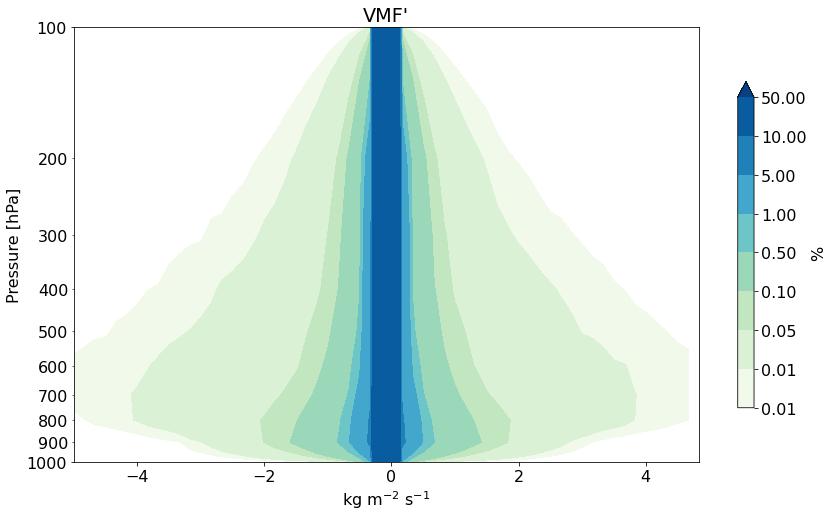

In [84]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title("VMF'")
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')

# fill contour
clevs=[0.005,0.01,0.05,0.1,0.5,1,5,10,50]

im = ax.contourf(wbins, pres, np.transpose(w_freq), clevs, locator=ticker.LogLocator(), \
                 cmap='GnBu', alpha=1, extend='max', zorder=2)

# X=wbins[0:nbin-1]
# Y=pres
# Z=np.transpose(w_freq)
# ax.pcolor(X, Y, Z, norm=colors.LogNorm(vmin=clevs[0], vmax=np.max(clevs)),
#                    cmap='PuBu', shading='auto')

ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlim(np.min(wbins), np.max(wbins))

# plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel(units_var2)

cbar = plt.colorbar(im, ax=ax, shrink=0.75)
cbar.ax.set_ylabel('%')

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)

/var/folders/8d/7vfq6vq90w341ddvxxt1k4540000gn/T/ipykernel_15341/3021550743.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf(thvbins[0:nbin-1], pres, np.transpose(thv_freq), clevs, locator=ticker.LogLocator(), \


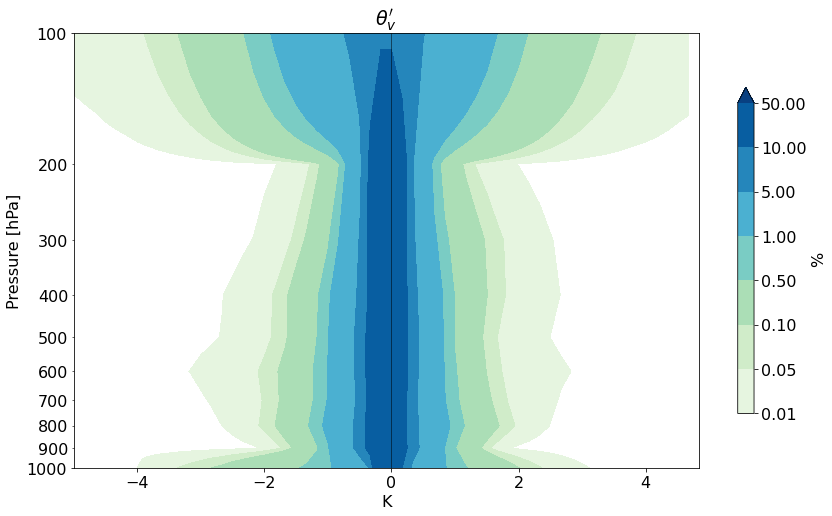

In [37]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title(r"$\theta_v'$")
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')

# fill contour
clevs=[0.01,0.05,0.1,0.5,1,5,10,50]

im = ax.contourf(thvbins, pres, np.transpose(thv_freq), clevs, locator=ticker.LogLocator(), \
                 cmap='GnBu', alpha=1, extend='max', zorder=2)

ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlim(np.min(thvbins), np.max(thvbins))

plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel('K')

cbar = plt.colorbar(im, ax=ax, shrink=0.75)
cbar.ax.set_ylabel('%')

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)

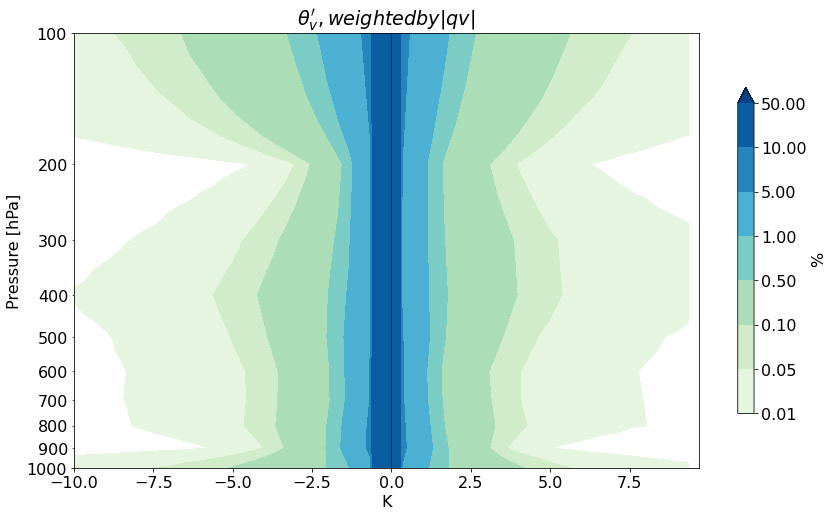

In [79]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title(r"$\theta_v', weighted by |qv|$")
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')

# fill contour
clevs=[0.01,0.05,0.1,0.5,1,5,10,50]

im = ax.contourf(thvbins, pres, np.transpose(thv_freq), clevs, locator=ticker.LogLocator(), \
                 cmap='GnBu', alpha=1, extend='max', zorder=2)

ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlim(np.min(thvbins), np.max(thvbins))

plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel('K')

cbar = plt.colorbar(im, ax=ax, shrink=0.75)
cbar.ax.set_ylabel('%')

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)

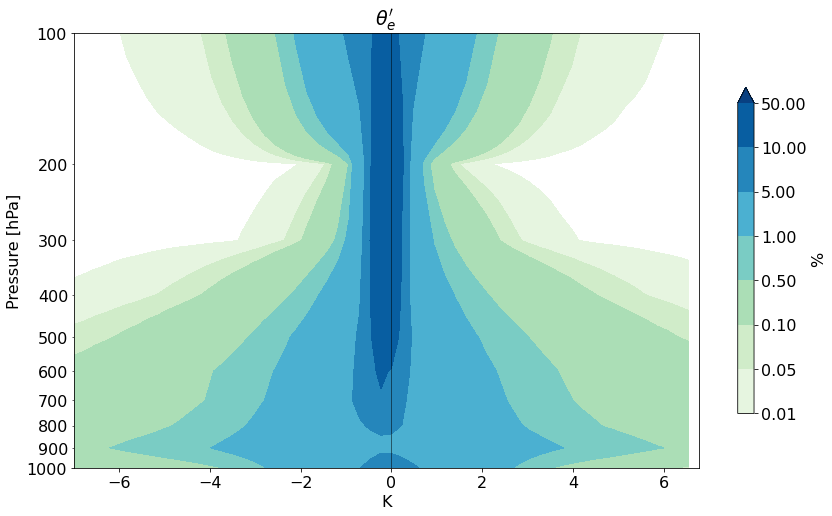

In [40]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title(r"$\theta_e'$")
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')

# fill contour
clevs=[0.01,0.05,0.1,0.5,1,5,10,50]

im = ax.contourf(thvbins, pres, np.transpose(thv_freq), clevs, locator=ticker.LogLocator(), \
                 cmap='GnBu', alpha=1, extend='max', zorder=2)

ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

plt.xlim(np.min(thvbins), np.max(thvbins))

plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel('K')

cbar = plt.colorbar(im, ax=ax, shrink=0.75)
cbar.ax.set_ylabel('%')

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)